# **Malicious URL Detection using a Neural Network Project**

### **Author: Rafael Santamaria**

## **PHASE 0: Import libraries**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

## **PHASE 1: Data Collection, URL Preprocessing, and Data Spliting** 

### Data Loader

In this cell I define a function to load the data from the dataset urldata.csv using pandas. 

In [2]:
#Defining a function to load the data 

def load_data(filepath):
    
    """
    Load URL data from CSV file
    Args: 
    Filepath representing location of csv doc.
    Returns: 
    Features X (URLs) and y (labels).
    """
    
    #Use Pandas read_csv method to prepare urldata.csv
    data=pd.read_csv(filepath)
    #Define X and y from "data" 
    #Extract values from 'url' column to a numpy array
    X=data['url'].values
    #Use .map to replace labels with 0's or 1's. Also .values to transform pandas series into numpy arrays.
    y=data['label'].map({'benign':0,'malicious':1}).values 
    #Return the values of X and y
    return X,y

### Data Splitting

In this cell I define a function to split data into training and test data

In [3]:
#Defining a function to split data

def split_data(X,y,test_size,random_state):
    '''
    Splits data into training and test sets.
    Args: 
    X_preprocessed (tokenized urls), y (labels), test_size (size of test data in %), random_state (shuffling of the data befor spliting).
    Returns: 
    X_train,X_test,y_train,y_test (training urls, test urls, train labels, test labels).
    '''
    
    #Use sklearn's train_test_split to create a test data set
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,random_state=random_state)
    #Return train and test data sets
    return X_train,X_test,y_train,y_test

### Preprocessor

In this cell I define a function to preprocess URLs using tensorflow/keras tokenizer.

In [4]:
#Defining a function to preprocess data and a tokenizer global variable to avoid fitting the tokenizer many times

tokenizer=None

def preprocessor_urls(urls):
    """
    Convert URLs to numerical features using tokenization.
    Args: 
    Urls exctracted from data set in variable X.
    Returns: 
    Urls preprocessed with tokenization X_preprocessed.
    """
    #Call global tokenizer to apply it just once in training
    global tokenizer
    #Keras tokenizer to tokenize each character in the URLs
    #"num_words" set to 1000 so that the model only focuses on the most frequent unique tokens, thus avoiding slow training and overfitting.
    #"char_level" ser to "True" so that the preprocessor represents urls with individual characters.
    if tokenizer is None:
        tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=1000,char_level=True)
        #Fit the tokenizer on the URLs
        tokenizer.fit_on_texts(urls)
    #Return the tokenized urls as a binary Matrix
    X_preprocessed=tokenizer.texts_to_matrix(urls, mode='binary')
    #Return preprocessed data
    return X_preprocessed #X_preprocessed

## **PHASE 2: Create, Train, and Test model**

### Create Model
In this cell I define a function to create a simple Neural Network model.

In [5]:
#Defining a function to create the model

def create_model(input_shape): #Call: model=create_model(X_train_preprocessed.shape[1:])
    """
    Create a neural network for URL classification
    
    Args: 
    input_dim (Shape of a single input sample (e.g., (1000,)) (X_train_preprocessed.shape[1:])
        
    Returns: 
    tf.keras.Model  (Compiled neural network model)
    """    
    #Create the NN using a Sequential model of Dense and Dropout layers
    #MODEL 1
    #model=Sequential([              
        #First Dense Layar
        #Dense(units=128,activation='relu',input_shape=input_shape,name='Dense_1'),
        #First Droput Layer
        #Dropout(0.3,name='Dropout_1'),
        #Second Dense Layer
        #Dense(units=64,activation='relu',name='Dense_2'),
        #Second Dropout Layer
        #Dropout(0.3,name='Dropout_2'),
        #Third Dense Layer
        #Dense(units=32,activation='relu',name='Dense_3'),
        #Third Dropout Layer
        #Dropout(0.3,name='Dropout_3'),
        #Dense Output Layer
        #Dense(1,activation='sigmoid',name='Output')        
    #],name='Neural_Natwork_for_Malicious_Url_Detection')
    #Model 2
    model=Sequential([
        #Input layer
        Input(shape=input_shape),
         # First Dense Layer
        Dense(units=128, name='Dense_1'), #128
        BatchNormalization(name='BatchNorm_1'),
        Activation('relu', name='Activation_1'),
        Dropout(0.3, name='Dropout_1'),
    
        # Second Dense Layer
        Dense(units=256, name='Dense_2'), #64
        BatchNormalization(name='BatchNorm_2'),
        Activation('relu', name='Activation_2'),
        Dropout(0.3, name='Dropout_2'),
    
        # Third Dense Layer
        Dense(units=128, name='Dense_3'), #32
        BatchNormalization(name='BatchNorm_3'),
        Activation('relu', name='Activation_3'),
        Dropout(0.3, name='Dropout_3'),

        # ADDED Fourth Dense Layer
        Dense(units=64, name='Dense_4'), 
        BatchNormalization(name='BatchNorm_4'),
        Activation('relu', name='Activation_4'),
        Dropout(0.3, name='Dropout_4'),

        # ADDED Fifth Dense Layer
        Dense(units=32, name='Dense_5'), 
        BatchNormalization(name='BatchNorm_5'),
        Activation('relu', name='Activation_5'),
        Dropout(0.3, name='Dropout_5'),
        
        # Dense Output Layer
        Dense(1, activation='sigmoid', name='Output')
    ], name='Neural_Network_for_Malicious_Url_Detection')

    #Compile the Model to configure it for training
    #model.compile(
        #optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        #loss=tf.keras.losses.BinaryCrossentropy(),
        #metrics=['accuracy', 'precision', 'recall']
    #)

    return model

### Train Model

In this cell I define a function to train the Model.

In [21]:
#Defining a function to train the model

def train_model(X_train_preprocessed,y_train,batch_size,epochs): #Call: model_trained,history=train_model(X_train,y_train,epochs,batch_size)
    """
    Create a neural network for URL classification
    
    Args:
    input_dim (int): Number of input features from tokenized URLs
        
    Returns:
    tf.keras.Model: Compiled neural network model
    """
    #Added class weights to increase recall
    class_weights=compute_class_weight('balanced',classes=np.unique(y_train),y=y_train)
    class_weight_dict=dict(enumerate(class_weights))
    
    #Compile the Model to configure it for training
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', 'precision', 'recall']
    )    
    
    #Define aerly stopping
    early_stopping=EarlyStopping(
        monitor='val_loss',
        patience=100,
        restore_best_weights=True)
    
    #Use the .fit method to train the model and save the history of training
    history=model.fit(
        x=X_train_preprocessed, 
        y=y_train,
        batch_size=batch_size, #Size of training data batches
        epochs=epochs, #Times it will perform formward and backwards propagation
        callbacks=[early_stopping], #Added early stopping
        class_weight=class_weight_dict, #Added class weights
        verbose=1,
        validation_split=0.1) #Save a bit of training data as cross-validation data

    return model,history

### Test the Model

In this cell I define a function to test model

In [7]:
#Evaluating the Model

def evaluate_model(X_test_preprocessed,y_test):
    #Define evaluation records to generate
    test_loss,test_accuracy,test_precision,test_recall=trained_model.evaluate(X_test_preprocessed,y_test,verbose=1)
    #Return the metrics
    return f'Loss: {test_loss}',f'Accuracy: {test_accuracy}',f'Precision: {test_precision}',f'Recall:{test_recall}'

## Phase 3: Predicting Maliciousness for Previously Unseen URL

### Prediction with the Model 

In this cell I define a function to use the model for predicting the maliciousness or not given a previously unseen URL.

In [8]:
#Prediction function

def predict_url(url,trained_model,threshold:float,tokenizer): #ADDED TOKENIZER
    #Preprocess the new url using tf.keras.text.Tokenizer
    preprocessed_url=tokenizer.texts_to_matrix([url],mode='binary') #Removed dependance on the preprocessor function
    #Use the tf.keras.Model.predict method on the new url
    prediction=trained_model.predict(preprocessed_url,verbose=0)[0][0]
    #Set the threshold
    if prediction>threshold:
        return f'{url} is likely MALICIOUS!: {prediction}' #close to 1
    else:
        return f'{url} is likely BENINGN!: {prediction}' #close to 0

## Phase 4: Implementing the Model

In [9]:
#Load data
X,y=load_data('urldata.csv')

In [10]:
#Split data into training and test data
X_train,X_test,y_train,y_test=split_data(X,y,0.1,42)
print(X_train.shape)

(405158,)


In [11]:
#with open('analysis.txt','w') as f:
    #f.write(X_train_w)
    #for i in y_train:
        #f.write(str(i))

In [12]:
#Preprocess data
X_train_preprocessed=preprocessor_urls(X_train)
X_test_preprocessed=preprocessor_urls(X_test)
print(X_train_preprocessed.shape[1:])

(1000,)


In [13]:
#Create the model
model=create_model((X_train_preprocessed.shape[1:])) #Shape (1000,) representing the 1000 features of each example

In [14]:
#Visualize model
model.summary()
print(f"Model input shape: {model.input_shape}")
#print(f"First layer input shape: {model.layers[0].input_shape}")

Model: "Neural_Network_for_Malicious_Url_Detection"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Dense_1 (Dense)                      │ (None, 128)                 │         128,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_1 (BatchNormalization)     │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_2 (BatchNormalization)     │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Activation_2 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_3 (BatchNormalization)     │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Activation_3 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_4 (BatchNormalization)     │ (None, 64)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Activation_4 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_5 (BatchNormalization)     │ (None, 32)                  │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Activation_5 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 206,849 (808.00 KB)

 Trainable params: 205,633 (803.25 KB)

 Non-trainable params: 1,216 (4.75 KB)

Model input shape: (None, 1000)


In [22]:
#Train the model (first test: 10 epochs, 32 batch size)
trained_model,history=train_model(X_train_preprocessed,y_train,256,110) #110 epochs visualization, new deeper NN, class weights

Epoch 1/110
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9096 - loss: 0.2584 - precision: 0.7826 - recall: 0.8416 - val_accuracy: 0.9224 - val_loss: 0.2205 - val_precision: 0.8401 - val_recall: 0.8226
Epoch 2/110
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9102 - loss: 0.2576 - precision: 0.7888 - recall: 0.8360 - val_accuracy: 0.9170 - val_loss: 0.2237 - val_precision: 0.8136 - val_recall: 0.8341
Epoch 3/110
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9091 - loss: 0.2592 - precision: 0.7823 - recall: 0.8412 - val_accuracy: 0.9217 - val_loss: 0.2154 - val_precision: 0.8374 - val_recall: 0.8227
Epoch 4/110
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9095 - loss: 0.2566 - precision: 0.7837 - recall: 0.8414 - val_accuracy: 0.9191 - val_loss: 0.2221 - val_precision: 0.8215 - val_recall: 0.8328
Epoch 5/110
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9091 - loss: 0.2588 - precision: 0.7844 - recall: 0.8414 - val_accuracy: 0.92

In [23]:
#Evaluate the Model
evaluate_model(X_test_preprocessed,y_test)

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1s 912us/step - accuracy: 0.9219 - loss: 0.2074 - precision: 0.8347 - recall: 0.8291


('Loss: 0.2092394232749939',
 'Accuracy: 0.9210538268089294',
 'Precision: 0.8312860131263733',
 'Recall:0.8282654285430908')

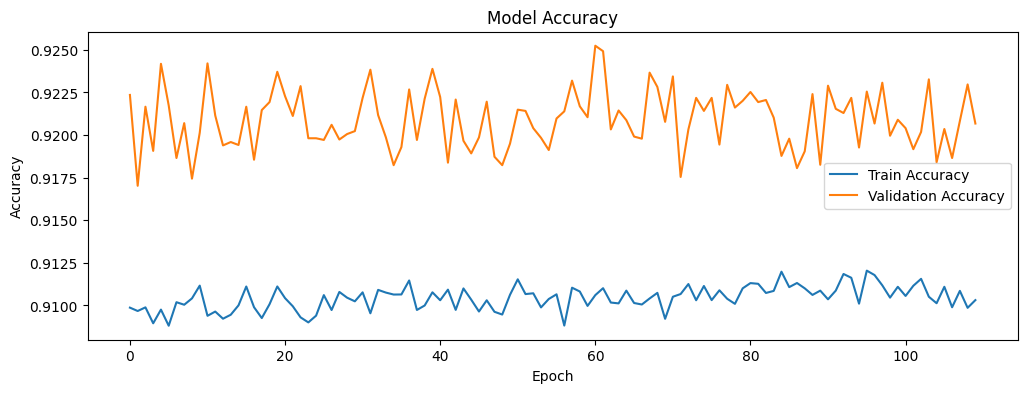

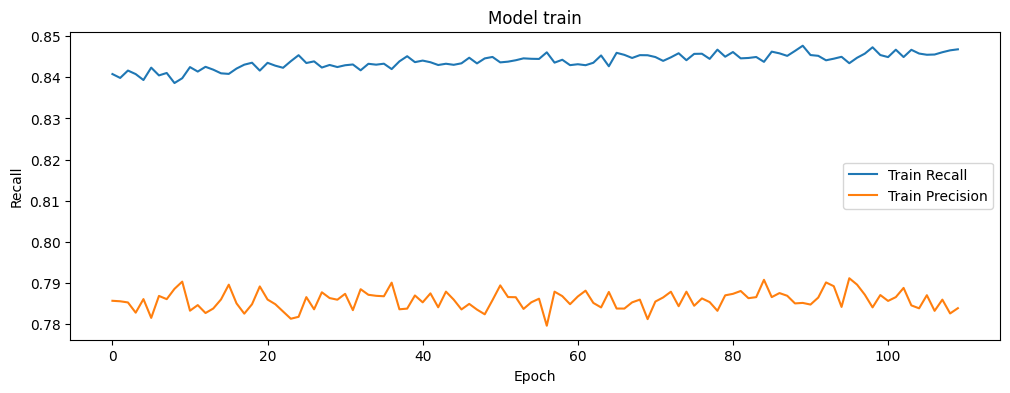

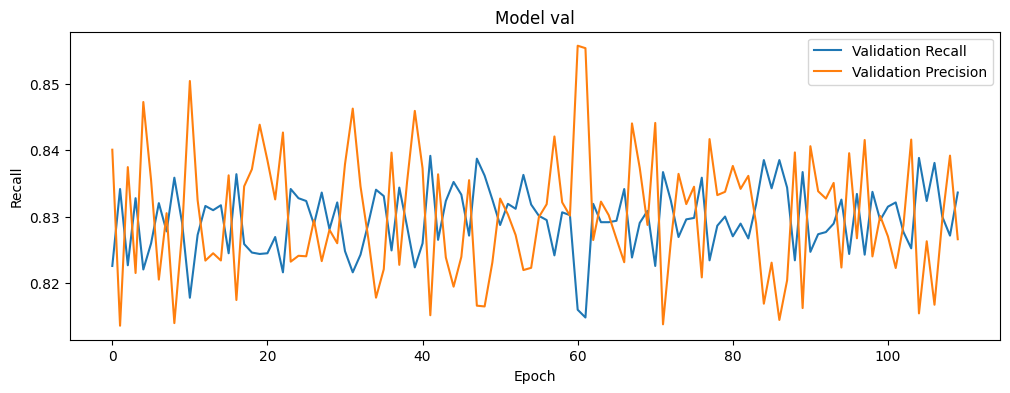

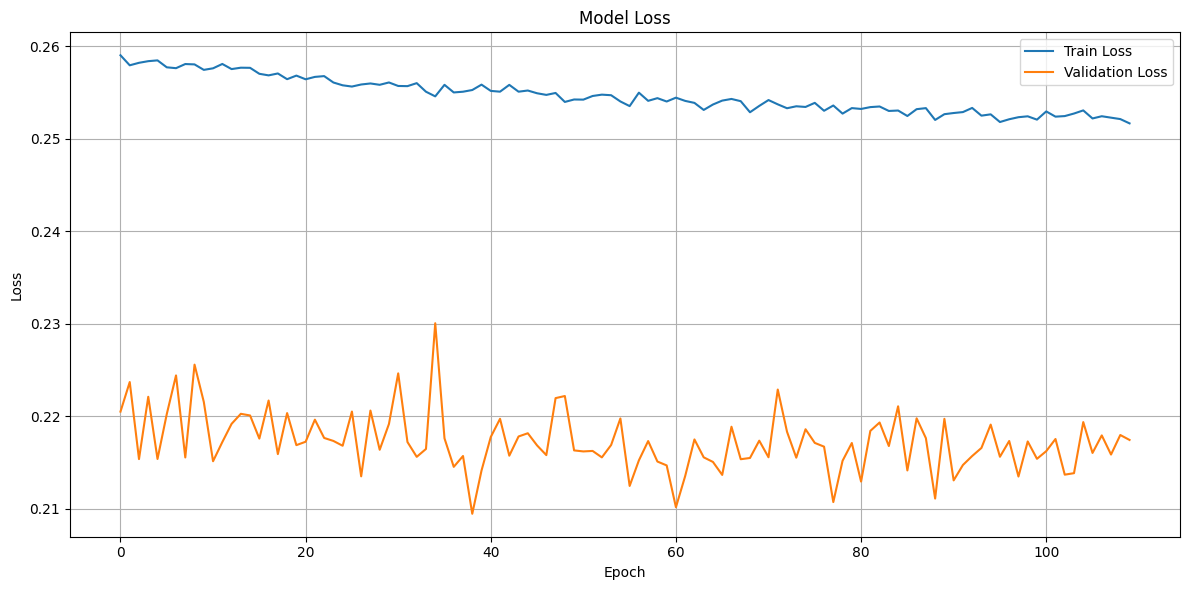

In [30]:
plt.figure(figsize=(12,4))
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(12,4))
plt.plot(history.history['recall'],label='Train Recall')
plt.plot(history.history['precision'],label='Train Precision')
plt.title('Model train')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.figure(figsize=(12,4))
plt.plot(history.history['val_recall'],label='Validation Recall')
plt.plot(history.history['val_precision'],label='Validation Precision')
plt.title('Model val')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.figure(figsize=(12, 6))
    
# Plot training & validation loss values
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')   
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [47]:
#Predict unknown URLs from the wild (https://urlhaus.abuse.ch/browse/)
threshold=0.3

url='http://59.88.229.17:60855/bin.sh'
predict_url(url,trained_model,threshold,tokenizer)

'http://59.88.229.17:60855/bin.sh is likely MALICIOUS!: 0.9999619126319885'

In [32]:
url='http://117.235.251.101:40567/Mozi.a'
predict_url(url,trained_model,threshold,tokenizer)

'http://117.235.251.101:40567/Mozi.a is likely MALICIOUS!: 0.9999975562095642'

In [33]:
url='http://117.219.47.18:38199/bin.sh'
predict_url(url,trained_model,threshold,tokenizer)

'http://117.219.47.18:38199/bin.sh is likely MALICIOUS!: 0.9999845623970032'

In [34]:
url='http://60.23.72.75:38513/i'
predict_url(url,trained_model,threshold,tokenizer)

'http://60.23.72.75:38513/i is likely MALICIOUS!: 0.9999909996986389'

In [35]:
url='http://125.41.227.80:54792/i'
predict_url(url,trained_model,threshold,tokenizer)

'http://125.41.227.80:54792/i is likely MALICIOUS!: 0.9999911189079285'

In [74]:
url='https://www.youtube.com/'
predict_url(url,trained_model,threshold,tokenizer)

'https://www.youtube.com/ is likely BENINGN!: 0.079730324447155'

In [ ]:
url='https://www.paulsantisiuniverse.com/'
predict_url(url,trained_model,threshold,tokenizer)

In [77]:
url='https://www.claude.ai/'
predict_url(url,trained_model,threshold,tokenizer)

'https://www.claude.ai/ is likely BENINGN!: 0.05178939923644066'

In [39]:
url='http://223.8.202.71:47344/i'
predict_url(url,trained_model,threshold,tokenizer)

'http://223.8.202.71:47344/i is likely MALICIOUS!: 0.9999920129776001'

In [40]:
url='http://175.175.28.107:59965/bin.sh'
predict_url(url,trained_model,threshold,tokenizer)

'http://175.175.28.107:59965/bin.sh is likely MALICIOUS!: 0.9999619126319885'

In [71]:
url='http://176.111.174.140/nuke.exe'
predict_url(url,trained_model,threshold,tokenizer)

'http://176.111.174.140/nuke.exe is likely MALICIOUS!: 0.9999897480010986'

In [46]:
url='https://www.semanariolacivilizacion.blogspot.com'
predict_url(url,trained_model,threshold,tokenizer)

'https://www.semanariolacivilizacion.blogspot.com is likely BENINGN!: 0.24499544501304626'

In [69]:
url='https://www.reddit.com'
predict_url(url,trained_model,threshold,tokenizer)

'https://www.reddit.com is likely BENINGN!: 0.0713285505771637'

In [51]:
#Test a huge list of fresh urls
url_list=[
    'http://64.235.37.148/bins/k.mips',
    'http://64.235.37.148/bins/k.m68k',
    'http://64.235.37.148/bins/k.x86',
    'http://31.172.80.237/qkdjdjj22.i586',
    'http://182.117.69.207:40583/i',
    'http://31.172.83.15/main_arm6',
    'http://31.162.21.98:40024/Mozi.m',
    'http://apitestlabs.com:8888/113681416431447.dll',
    'http://cloudslimit.com:8888/113681416431447.dll',
    'http://dailywebstats.com:8888/225761669829717.dll',
    'https://www.discord.com',
    'http://94.159.113.48:8888/113681416431447.dll',
    'http://87.120.114.132/mirai.arm7',
    'https://chxr.rooms.fierceatfifty.com/orderReview',
    'http://87.120.114.132/mirai.ppc',
    'http://whimar.com/wp-admin/maint/XjoPqhzc228.bin',
    'http://whimar.com/wp-admin/maint/Verificerbarheden.mso',
    'http://185.215.113.16/mine/random.exe',
    'https://wall5tghf6fdg.api.opensourcesaas.org/FcPJXgYD/mine.png',
    'http://87.120.112.102/roze.i586',
    'http://103.72.57.120/TGIF/Jodozocw.dat',
    'https://www.semanariolacivilizacion.blogspot.com',
    'http://172.245.123.25/302/taskhostws.exe',
    'http://157.173.104.153/up/bb.ps1',
    'http://107.170.34.159/morsec/Invoke-Shellcode.ps1',
    'http://157.173.104.153/up/Tool/ChromePass.exe',
    'http://101.99.94.195/mZlaoZbpEVWPJcG210.bin',
    'http://124.248.65.242:8899/sys/20230120_3.bin',
    'http://invictaindia.com/sty/iTSqHIazA174.bin',
    'http://invictaindia.com/sty1/Kajanlggenes.u32',
    'http://8.138.96.41:10050/demon.x64.bin',
    'http://169.1.16.29/swift-bypass-breakpoints.exe',
    'https://www.mincultura.gov.co',
    'http://169.1.16.29/demon.x641.exe',
    'http://169.1.16.29/BidvestBank-Swift-DNS-Tunnel.exe',
    'http://169.1.16.29/BidvestBank-Swift--DNS-evasion-encrypted-no-cloudflare.exe',
    'http://169.1.16.29/LOUD_EYE',
    'http://169.1.16.29/Swift-Beacon-Encrypted.exe',
    'http://178.215.238.13/r.sh',
    'http://91.218.67.59/wget.sh',
    'http://87.120.112.102/update.sh',
    'http://120.25.157.131/qz1.exe',
    'http://185.121.233.82/tt/mips64',
    'https://www.gamebooks.org',
    'http://github.com/vizian123/msfvenomz/raw/main/reddit.exe',
    'https://pastebin.com/raw/FYu4F1YR',
    'http://120.25.157.131/fsx.exe',
    'https://www.ydray.com/get/t/u17290663674746gFwb38bd70be00c5oQ',
    'https://bitbucket.org/awgwrtwa/asss/downloads/1654-INICIO_DEMANDA_LABORAL_JUZGADO_CIVIL_DEL_CIRCUITO_DE_RAMA_JUDICIAL.CAB',
    'http://47.236.122.191/Geek.exe',
    'http://176.111.174.140/ywx.exe',
    'http://web.johnmccrea.com/downloads/67065227a0640_rrrrrrrr.exe'
]
#Start a count
count=0

#Parse urls
for u in url_list:
    #Call custom predict function in every url
    count+=1
    print(count,predict_url(u,trained_model,threshold,tokenizer))

1 http://64.235.37.148/bins/k.mips is likely MALICIOUS!: 0.9999939203262329
2 http://64.235.37.148/bins/k.m68k is likely MALICIOUS!: 0.9999939203262329
3 http://64.235.37.148/bins/k.x86 is likely MALICIOUS!: 0.9999952912330627
4 http://31.172.80.237/qkdjdjj22.i586 is likely MALICIOUS!: 0.9999898076057434
5 http://182.117.69.207:40583/i is likely MALICIOUS!: 0.9999951720237732
6 http://31.172.83.15/main_arm6 is likely MALICIOUS!: 0.9999966621398926
7 http://31.162.21.98:40024/Mozi.m is likely MALICIOUS!: 0.9999939799308777
8 http://apitestlabs.com:8888/113681416431447.dll is likely MALICIOUS!: 0.9994522929191589
9 http://cloudslimit.com:8888/113681416431447.dll is likely MALICIOUS!: 0.9998060464859009
10 http://dailywebstats.com:8888/225761669829717.dll is likely BENINGN!: 0.026539182290434837
11 https://www.discord.com is likely BENINGN!: 0.07051538676023483
12 http://94.159.113.48:8888/113681416431447.dll is likely MALICIOUS!: 0.9999892711639404
13 http://87.120.114.132/mirai.arm7 is 

In [ ]:
#Add more malicious urls to data set. Special focus in crypto miners
#Create the list of additions
to_add=[
    'http://cache.ussc.org/downloads/67065227a0640_rrrrrrrr.exe',
    'http://assets.padmamuseum.gov.bd/downloads/67065227a0640_rrrrrrrr.exe',
    'http://147.45.47.185/downloads/67065227a0640_rrrrrrrr.exe',
    'http://lide.omernisar.com/revada/66c6fcb30b9dd_123p.exe',
    'http://heks.egrowbrands.com/lopsa/66ea645129e6a_jacobs.exe',
    'http://heks.egrowbrands.com/revada/66c6fcb30b9dd_123p.exe',
    'http://lide.omernisar.com/prog/66f904cda3b3f_fusion.exe',
    'http://lide.omernisar.com/lopsa/66dd2c2d3b88f_opera.exe',
    'http://heks.egrowbrands.com/prog/66c2d861a5b4d_google.exe',
    'http://mkas.rizwanmano.com/lopsa/66dd2c2d3b88f_opera.exe',
    'http://heks.egrowbrands.com/prog/66f904cda3b3f_fusion.exe',
    'http://heks.egrowbrands.com/lopsa/66c6efd6b6f8b_123p.exe',
    'http://alcatraz.pro.et/Recaller.zip',
    'http://220.149.212.17:8080/js/xmrig.zip',
    'http://112.217.207.130/js/s.rar',
    'http://154.216.19.227/2.txt',
    'http://154.216.19.227/3.txt',
    'http://154.216.19.227/4.txt',
    'http://main.dsn.ovh/dns/pwer',
    'http://hss.myftp.biz:11455/Windows.exe',
    'http://hss.myftp.biz:11455/update.exe',
    'http://178.124.176.209:11455/Windows.exe',
    'http://178.124.176.209:11455/update.exe',
    'http://217.28.220.132/tools/payload.exe',
    'http://217.28.220.132/tools/payload.ps1',
    'https://utka.xyz/1234.exe',
    'http://87.120.117.92/sh',
    'http://154.216.19.227/az',
    'http://121.62.21.150:25896/jkvgv.exe',
    'https://pastebin.com/raw/FYu4F1YR',
    'http://154.216.17.30/redtail.arm7'
]

#Open the file to append rows
with open('urldata - Copy.csv','a') as file:
    #loop through every url to add
    for u_add in to_add:
        #Create the row to add
        #row_to_add=u_add
        #Add the row
        file.write(u_add)

print('Done!')
    